In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt

/Users/kuoteng/.pyenv/versions/3.6.4/envs/NCKU-DSAI/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
DATA_SIZE = 60000
TRAIN_SIZE = 45000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
EPOCH_SIZE = 1
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '-',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
%time
questions = []
expected = []
seen = set()
print('Generating data...')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.06 µs
Generating data...


In [8]:
%time
while len(questions) < DATA_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    a, b = (a, b) if a > b else (b, a)
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
Total addition questions: 60000


In [9]:
print(questions[:5], expected[:5])

['64-1   ', '993-865', '54-5   ', '951-111', '876-1  '] ['63  ', '128 ', '49  ', '840 ', '875 ']


# Processing

In [10]:
print('Vectorization... (to the one-hot encoding)')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization... (to the one-hot encoding)


In [11]:
indices = np.arange(len(y))
np.random.shuffle(indices)
print(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:TRAIN_SIZE]
train_y = y[:TRAIN_SIZE]
test_x = x[TRAIN_SIZE:]
test_y = y[TRAIN_SIZE:]

print('Training Data:')
print(train_x.shape)
print(train_y.shape)

split_at = len(train_x) - len(train_x) // 10
print('split_at', split_at)
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)


[13869 42999 15951 ... 52575 44003 41749]
Training Data:
(45000, 7, 12)
(45000, 4, 12)
split_at 40500
Training Data:
(40500, 7, 12)
(40500, 4, 12)
Validation Data:
(4500, 7, 12)
(4500, 4, 12)
Testing Data:
(15000, 7, 12)
(15000, 4, 12)


In [12]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False  True False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False  True False False False False False
   False]
  [False False False False  True False False False False False False
   False]
  [ True False False False False False False False False False False
   False]
  [ True False False False False False False False False False False
   False]]

 [[False False False False False False False False  True False False
   False]
  [False False False False False False False  True False False False
   False]
  [False False False False False False False False False False False
    True]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False  True False False False
   False]
  [False False False False  True False Fal

# Build Model

In [13]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

In [14]:
acc = []
val_acc = []
loss = []
val_loss = []
guesses = []
for loop in range(100):
    print()
    print('-' * 50)
    print('Train Loop Num:', loop)
    history = model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCH_SIZE,
                  validation_data=(x_val, y_val),
                  shuffle=True)
    acc += history.history['acc']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    val_loss += history.history['val_loss']
    right = 0
    preds = model.predict_classes(test_x, verbose=0)
    for i in range(len(preds)):
        q = ctable.decode(test_x[i])
        correct = ctable.decode(test_y[i])
        guess = ctable.decode(preds[i], calc_argmax=False)
        if correct == guess:
            right += 1
    print("MSG : Accuracy is {}".format(right / len(preds)))
    guesses.append(right / len(preds))


--------------------------------------------------
Train Loop Num: 0
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 10s 256us/step - loss: 1.7811 - acc: 0.3472 - val_loss: 1.6318 - val_acc: 0.3838
MSG : Accuracy is 0.0029333333333333334

--------------------------------------------------
Train Loop Num: 1
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 10s 240us/step - loss: 1.5808 - acc: 0.4094 - val_loss: 1.5137 - val_acc: 0.4409
MSG : Accuracy is 0.007066666666666666

--------------------------------------------------
Train Loop Num: 2
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 231us/step - loss: 1.4436 - acc: 0.4655 - val_loss: 1.3943 - val_acc: 0.4934
MSG : Accuracy is 0.010266666666666667

--------------------------------------------------
Train Loop Num: 3
Train on 40500 samples, validate on 4500 s

40500/40500 [==============================] - 8s 208us/step - loss: 0.1149 - acc: 0.9705 - val_loss: 0.1228 - val_acc: 0.9659
MSG : Accuracy is 0.8679333333333333

--------------------------------------------------
Train Loop Num: 29
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 8s 206us/step - loss: 0.1080 - acc: 0.9716 - val_loss: 0.1173 - val_acc: 0.9667
MSG : Accuracy is 0.8756

--------------------------------------------------
Train Loop Num: 30
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 8s 203us/step - loss: 0.0954 - acc: 0.9765 - val_loss: 0.1127 - val_acc: 0.9649
MSG : Accuracy is 0.8718

--------------------------------------------------
Train Loop Num: 31
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 8s 205us/step - loss: 0.0910 - acc: 0.9765 - val_loss: 0.1125 - val_acc: 0.9653
MSG : Accuracy 

40500/40500 [==============================] - 10s 247us/step - loss: 0.0315 - acc: 0.9917 - val_loss: 0.1300 - val_acc: 0.9547
MSG : Accuracy is 0.8375333333333334

--------------------------------------------------
Train Loop Num: 58
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 220us/step - loss: 0.0487 - acc: 0.9853 - val_loss: 0.0325 - val_acc: 0.9912
MSG : Accuracy is 0.963

--------------------------------------------------
Train Loop Num: 59
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 220us/step - loss: 0.0197 - acc: 0.9960 - val_loss: 0.0342 - val_acc: 0.9898
MSG : Accuracy is 0.9612666666666667

--------------------------------------------------
Train Loop Num: 60
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 226us/step - loss: 0.0195 - acc: 0.9961 - val_loss: 0.0324 - val_acc: 0.9909
MSG

40500/40500 [==============================] - 9s 222us/step - loss: 0.0085 - acc: 0.9990 - val_loss: 0.0194 - val_acc: 0.9947
MSG : Accuracy is 0.9772666666666666

--------------------------------------------------
Train Loop Num: 86
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 221us/step - loss: 0.0081 - acc: 0.9989 - val_loss: 0.0244 - val_acc: 0.9928
MSG : Accuracy is 0.9732

--------------------------------------------------
Train Loop Num: 87
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 228us/step - loss: 0.0098 - acc: 0.9983 - val_loss: 0.0365 - val_acc: 0.9886
MSG : Accuracy is 0.9562666666666667

--------------------------------------------------
Train Loop Num: 88
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 9s 230us/step - loss: 0.0452 - acc: 0.9855 - val_loss: 0.0331 - val_acc: 0.9894
MSG

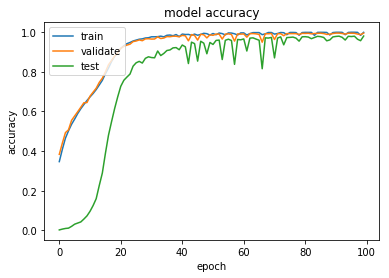

In [15]:
plt.plot(acc)
plt.plot(val_acc)
plt.plot(guesses)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate', 'test'], loc='upper left')
plt.savefig('./fig/subtractor-jupyter-accuracy.png')
plt.show()

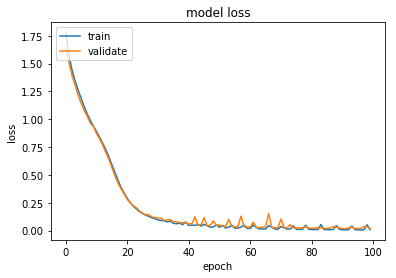

In [16]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.savefig('./fig/subtractor-jupyter-loss.png')
plt.show()

# Testing

In [17]:
print("MSG : Prediction")
print("-" * 50)
right = 0
preds = model.predict_classes(test_x, verbose=0)
for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

MSG : Prediction
--------------------------------------------------
Q 78-30   T 48   ☑ 48  
Q 835-243 T 592  ☑ 592 
Q 41-25   T 16   ☑ 16  
Q 94-30   T 64   ☑ 64  
Q 709-267 T 442  ☑ 442 
Q 489-443 T 46   ☑ 46  
Q 703-600 T 103  ☑ 103 
Q 933-33  T 900  ☑ 900 
Q 253-186 T 67   ☑ 67  
Q 698-285 T 413  ☑ 413 
Q 37-7    T 30   ☑ 30  
Q 709-107 T 602  ☑ 602 
Q 883-347 T 536  ☑ 536 
Q 584-38  T 546  ☑ 546 
Q 612-326 T 286  ☑ 286 
Q 628-237 T 391  ☑ 391 
Q 762-13  T 749  ☑ 749 
Q 522-282 T 240  ☑ 240 
Q 316-20  T 296  ☑ 296 
Q 776-655 T 121  ☑ 121 
Q 605-40  T 565  ☑ 565 
Q 682-90  T 592  ☑ 592 
Q 598-361 T 237  ☑ 237 
Q 898-818 T 80   ☒ 70  
Q 603-75  T 528  ☑ 528 
Q 639-285 T 354  ☑ 354 
Q 836-46  T 790  ☑ 790 
Q 313-89  T 224  ☑ 224 
Q 254-98  T 156  ☑ 156 
Q 795-525 T 270  ☑ 270 
Q 936-6   T 930  ☑ 930 
Q 324-22  T 302  ☑ 302 
Q 845-3   T 842  ☑ 842 
Q 324-65  T 259  ☑ 259 
Q 957-865 T 92   ☑ 92  
Q 492-247 T 245  ☑ 245 
Q 294-52  T 242  ☑ 242 
Q 687-42  T 645  ☑ 645 
Q 189-52  T 137  ☑ 1

Q 513-39  T 474  ☑ 474 
Q 562-127 T 435  ☑ 435 
Q 482-61  T 421  ☑ 421 
Q 916-412 T 504  ☑ 504 
Q 523-30  T 493  ☑ 493 
Q 186-83  T 103  ☑ 103 
Q 395-89  T 306  ☑ 306 
Q 506-33  T 473  ☑ 473 
Q 292-54  T 238  ☑ 238 
Q 275-46  T 229  ☑ 229 
Q 871-449 T 422  ☑ 422 
Q 393-30  T 363  ☑ 363 
Q 428-57  T 371  ☑ 371 
Q 221-0   T 221  ☑ 221 
Q 653-15  T 638  ☑ 638 
Q 200-6   T 194  ☑ 194 
Q 685-33  T 652  ☑ 652 
Q 680-187 T 493  ☑ 493 
Q 978-236 T 742  ☑ 742 
Q 672-191 T 481  ☑ 481 
Q 24-17   T 7    ☑ 7   
Q 828-573 T 255  ☑ 255 
Q 387-64  T 323  ☑ 323 
Q 224-68  T 156  ☑ 156 
Q 957-7   T 950  ☑ 950 
Q 97-30   T 67   ☑ 67  
Q 972-758 T 214  ☑ 214 
Q 552-222 T 330  ☑ 330 
Q 920-728 T 192  ☑ 192 
Q 189-31  T 158  ☑ 158 
Q 651-462 T 189  ☑ 189 
Q 967-965 T 2    ☒ 1   
Q 736-684 T 52   ☑ 52  
Q 805-185 T 620  ☑ 620 
Q 682-7   T 675  ☑ 675 
Q 934-30  T 904  ☑ 904 
Q 228-50  T 178  ☑ 178 
Q 281-2   T 279  ☑ 279 
Q 563-511 T 52   ☑ 52  
Q 300-1   T 299  ☑ 299 
Q 89-79   T 10   ☑ 10  
Q 918-259 T 659 

Q 828-80  T 748  ☑ 748 
Q 899-5   T 894  ☑ 894 
Q 876-852 T 24   ☑ 24  
Q 442-95  T 347  ☑ 347 
Q 410-5   T 405  ☑ 405 
Q 609-23  T 586  ☑ 586 
Q 590-209 T 381  ☑ 381 
Q 767-7   T 760  ☑ 760 
Q 506-56  T 450  ☑ 450 
Q 876-45  T 831  ☑ 831 
Q 806-214 T 592  ☑ 592 
Q 450-38  T 412  ☑ 412 
Q 104-81  T 23   ☑ 23  
Q 451-438 T 13   ☑ 13  
Q 77-62   T 15   ☑ 15  
Q 699-120 T 579  ☒ 589 
Q 616-430 T 186  ☑ 186 
Q 825-753 T 72   ☑ 72  
Q 150-94  T 56   ☑ 56  
Q 324-33  T 291  ☑ 291 
Q 98-63   T 35   ☑ 35  
Q 346-50  T 296  ☑ 296 
Q 920-724 T 196  ☑ 196 
Q 790-40  T 750  ☑ 750 
Q 80-42   T 38   ☑ 38  
Q 437-99  T 338  ☑ 338 
Q 762-46  T 716  ☑ 716 
Q 683-189 T 494  ☑ 494 
Q 954-91  T 863  ☑ 863 
Q 455-99  T 356  ☑ 356 
Q 236-6   T 230  ☑ 230 
Q 290-53  T 237  ☑ 237 
Q 33-20   T 13   ☑ 13  
Q 92-12   T 80   ☑ 80  
Q 762-33  T 729  ☑ 729 
Q 242-2   T 240  ☑ 240 
Q 597-80  T 517  ☑ 517 
Q 214-6   T 208  ☑ 208 
Q 977-439 T 538  ☑ 538 
Q 503-285 T 218  ☑ 218 
Q 301-229 T 72   ☑ 72  
Q 460-81  T 379 

Q 410-44  T 366  ☑ 366 
Q 422-29  T 393  ☑ 393 
Q 993-8   T 985  ☑ 985 
Q 478-55  T 423  ☑ 423 
Q 122-6   T 116  ☑ 116 
Q 71-58   T 13   ☑ 13  
Q 698-3   T 695  ☑ 695 
Q 181-47  T 134  ☑ 134 
Q 928-98  T 830  ☑ 830 
Q 949-433 T 516  ☑ 516 
Q 700-441 T 259  ☑ 259 
Q 845-56  T 789  ☑ 789 
Q 368-29  T 339  ☑ 339 
Q 641-10  T 631  ☑ 631 
Q 232-9   T 223  ☑ 223 
Q 433-84  T 349  ☑ 349 
Q 929-2   T 927  ☑ 927 
Q 480-5   T 475  ☑ 475 
Q 410-39  T 371  ☑ 371 
Q 297-8   T 289  ☑ 289 
Q 514-12  T 502  ☑ 502 
Q 499-28  T 471  ☑ 471 
Q 448-354 T 94   ☑ 94  
Q 606-10  T 596  ☑ 596 
Q 154-86  T 68   ☑ 68  
Q 670-6   T 664  ☑ 664 
Q 494-85  T 409  ☑ 409 
Q 654-7   T 647  ☑ 647 
Q 592-304 T 288  ☑ 288 
Q 723-0   T 723  ☑ 723 
Q 326-84  T 242  ☑ 242 
Q 967-95  T 872  ☑ 872 
Q 315-0   T 315  ☑ 315 
Q 676-39  T 637  ☑ 637 
Q 53-40   T 13   ☑ 13  
Q 617-82  T 535  ☑ 535 
Q 115-6   T 109  ☑ 109 
Q 695-589 T 106  ☑ 106 
Q 489-475 T 14   ☒ 24  
Q 46-28   T 18   ☑ 18  
Q 844-76  T 768  ☑ 768 
Q 967-218 T 749 

Q 453-106 T 347  ☒ 346 
Q 414-3   T 411  ☑ 411 
Q 967-833 T 134  ☑ 134 
Q 93-29   T 64   ☑ 64  
Q 489-49  T 440  ☑ 440 
Q 643-42  T 601  ☑ 601 
Q 602-61  T 541  ☑ 541 
Q 164-95  T 69   ☑ 69  
Q 251-70  T 181  ☑ 181 
Q 97-48   T 49   ☑ 49  
Q 438-0   T 438  ☑ 438 
Q 528-270 T 258  ☑ 258 
Q 658-89  T 569  ☑ 569 
Q 162-14  T 148  ☑ 148 
Q 683-85  T 598  ☑ 598 
Q 444-61  T 383  ☑ 383 
Q 736-449 T 287  ☑ 287 
Q 964-100 T 864  ☑ 864 
Q 681-8   T 673  ☑ 673 
Q 87-22   T 65   ☑ 65  
Q 776-33  T 743  ☑ 743 
Q 948-60  T 888  ☑ 888 
Q 418-317 T 101  ☑ 101 
Q 760-8   T 752  ☑ 752 
Q 764-59  T 705  ☑ 705 
Q 147-120 T 27   ☒ 17  
Q 391-136 T 255  ☑ 255 
Q 777-509 T 268  ☑ 268 
Q 75-22   T 53   ☑ 53  
Q 609-27  T 582  ☑ 582 
Q 831-440 T 391  ☑ 391 
Q 34-1    T 33   ☑ 33  
Q 920-623 T 297  ☑ 297 
Q 512-77  T 435  ☑ 435 
Q 370-32  T 338  ☑ 338 
Q 465-78  T 387  ☑ 387 
Q 338-70  T 268  ☑ 268 
Q 602-117 T 485  ☑ 485 
Q 257-19  T 238  ☑ 238 
Q 215-29  T 186  ☑ 186 
Q 351-84  T 267  ☑ 267 
Q 202-1   T 201 

Q 418-59  T 359  ☑ 359 
Q 520-51  T 469  ☑ 469 
Q 571-319 T 252  ☑ 252 
Q 255-99  T 156  ☑ 156 
Q 992-342 T 650  ☑ 650 
Q 924-345 T 579  ☑ 579 
Q 106-1   T 105  ☑ 105 
Q 583-62  T 521  ☑ 521 
Q 197-5   T 192  ☑ 192 
Q 800-95  T 705  ☑ 705 
Q 85-64   T 21   ☑ 21  
Q 353-63  T 290  ☑ 290 
Q 549-514 T 35   ☑ 35  
Q 225-12  T 213  ☑ 213 
Q 288-27  T 261  ☑ 261 
Q 50-38   T 12   ☑ 12  
Q 181-37  T 144  ☑ 144 
Q 971-895 T 76   ☑ 76  
Q 727-301 T 426  ☑ 426 
Q 16-3    T 13   ☑ 13  
Q 57-7    T 50   ☑ 50  
Q 107-99  T 8    ☒ 9   
Q 362-23  T 339  ☑ 339 
Q 702-203 T 499  ☑ 499 
Q 614-13  T 601  ☑ 601 
Q 726-7   T 719  ☑ 719 
Q 860-3   T 857  ☑ 857 
Q 733-703 T 30   ☑ 30  
Q 806-19  T 787  ☑ 787 
Q 843-84  T 759  ☑ 759 
Q 42-42   T 0    ☑ 0   
Q 996-673 T 323  ☑ 323 
Q 978-732 T 246  ☑ 246 
Q 21-8    T 13   ☑ 13  
Q 904-79  T 825  ☑ 825 
Q 860-732 T 128  ☑ 128 
Q 424-259 T 165  ☑ 165 
Q 222-16  T 206  ☑ 206 
Q 635-93  T 542  ☑ 542 
Q 423-75  T 348  ☑ 348 
Q 349-305 T 44   ☑ 44  
Q 927-30  T 897 

Q 94-56   T 38   ☑ 38  
Q 571-3   T 568  ☑ 568 
Q 568-98  T 470  ☑ 470 
Q 258-13  T 245  ☑ 245 
Q 196-72  T 124  ☑ 124 
Q 600-53  T 547  ☑ 547 
Q 488-91  T 397  ☑ 397 
Q 148-122 T 26   ☑ 26  
Q 763-33  T 730  ☑ 730 
Q 612-446 T 166  ☑ 166 
Q 928-541 T 387  ☑ 387 
Q 94-36   T 58   ☑ 58  
Q 829-2   T 827  ☑ 827 
Q 69-68   T 1    ☑ 1   
Q 438-215 T 223  ☑ 223 
Q 268-168 T 100  ☑ 100 
Q 717-101 T 616  ☑ 616 
Q 662-474 T 188  ☑ 188 
Q 435-94  T 341  ☑ 341 
Q 711-635 T 76   ☑ 76  
Q 937-18  T 919  ☑ 919 
Q 831-34  T 797  ☑ 797 
Q 567-5   T 562  ☑ 562 
Q 989-31  T 958  ☑ 958 
Q 538-85  T 453  ☑ 453 
Q 104-2   T 102  ☑ 102 
Q 242-25  T 217  ☑ 217 
Q 119-25  T 94   ☑ 94  
Q 823-41  T 782  ☑ 782 
Q 549-520 T 29   ☒ 19  
Q 672-66  T 606  ☑ 606 
Q 155-92  T 63   ☑ 63  
Q 406-228 T 178  ☑ 178 
Q 625-351 T 274  ☑ 274 
Q 91-21   T 70   ☑ 70  
Q 321-5   T 316  ☑ 316 
Q 178-96  T 82   ☑ 82  
Q 163-55  T 108  ☑ 108 
Q 376-62  T 314  ☑ 314 
Q 906-626 T 280  ☑ 280 
Q 598-62  T 536  ☑ 536 
Q 439-85  T 354 

Q 525-72  T 453  ☑ 453 
Q 16-1    T 15   ☑ 15  
Q 24-20   T 4    ☑ 4   
Q 475-464 T 11   ☑ 11  
Q 730-99  T 631  ☑ 631 
Q 520-58  T 462  ☑ 462 
Q 518-152 T 366  ☑ 366 
Q 461-58  T 403  ☑ 403 
Q 888-359 T 529  ☑ 529 
Q 273-74  T 199  ☑ 199 
Q 203-144 T 59   ☒ 69  
Q 39-0    T 39   ☑ 39  
Q 601-507 T 94   ☑ 94  
Q 740-27  T 713  ☑ 713 
Q 813-2   T 811  ☑ 811 
Q 386-323 T 63   ☑ 63  
Q 81-54   T 27   ☑ 27  
Q 545-26  T 519  ☑ 519 
Q 801-43  T 758  ☑ 758 
Q 669-88  T 581  ☑ 581 
Q 274-73  T 201  ☑ 201 
Q 679-84  T 595  ☑ 595 
Q 243-63  T 180  ☑ 180 
Q 471-386 T 85   ☑ 85  
Q 551-4   T 547  ☑ 547 
Q 742-76  T 666  ☑ 666 
Q 951-634 T 317  ☑ 317 
Q 796-61  T 735  ☑ 735 
Q 62-26   T 36   ☑ 36  
Q 602-9   T 593  ☑ 593 
Q 468-342 T 126  ☑ 126 
Q 768-398 T 370  ☑ 370 
Q 94-26   T 68   ☑ 68  
Q 152-2   T 150  ☑ 150 
Q 135-61  T 74   ☑ 74  
Q 649-5   T 644  ☑ 644 
Q 240-236 T 4    ☒ 5   
Q 952-835 T 117  ☑ 117 
Q 923-23  T 900  ☑ 900 
Q 705-436 T 269  ☑ 269 
Q 569-538 T 31   ☑ 31  
Q 683-210 T 473 

Q 300-137 T 163  ☑ 163 
Q 230-71  T 159  ☑ 159 
Q 204-9   T 195  ☑ 195 
Q 873-4   T 869  ☑ 869 
Q 85-16   T 69   ☑ 69  
Q 151-73  T 78   ☑ 78  
Q 530-6   T 524  ☑ 524 
Q 880-123 T 757  ☑ 757 
Q 39-14   T 25   ☑ 25  
Q 496-52  T 444  ☑ 444 
Q 88-75   T 13   ☑ 13  
Q 724-46  T 678  ☑ 678 
Q 863-96  T 767  ☑ 767 
Q 925-7   T 918  ☑ 918 
Q 77-9    T 68   ☑ 68  
Q 622-279 T 343  ☑ 343 
Q 688-34  T 654  ☑ 654 
Q 670-39  T 631  ☑ 631 
Q 941-770 T 171  ☑ 171 
Q 628-441 T 187  ☑ 187 
Q 520-480 T 40   ☒ 30  
Q 747-10  T 737  ☑ 737 
Q 987-58  T 929  ☑ 929 
Q 786-487 T 299  ☑ 299 
Q 245-156 T 89   ☒ 99  
Q 848-768 T 80   ☑ 80  
Q 876-817 T 59   ☒ 69  
Q 772-455 T 317  ☑ 317 
Q 151-46  T 105  ☑ 105 
Q 92-88   T 4    ☑ 4   
Q 99-71   T 28   ☑ 28  
Q 825-720 T 105  ☑ 105 
Q 815-76  T 739  ☑ 739 
Q 578-29  T 549  ☑ 549 
Q 88-48   T 40   ☑ 40  
Q 651-97  T 554  ☑ 554 
Q 654-82  T 572  ☑ 572 
Q 715-6   T 709  ☑ 709 
Q 313-27  T 286  ☑ 286 
Q 660-88  T 572  ☑ 572 
Q 178-30  T 148  ☑ 148 
Q 103-44  T 59  

Q 228-6   T 222  ☑ 222 
Q 950-188 T 762  ☑ 762 
Q 413-52  T 361  ☑ 361 
Q 84-10   T 74   ☑ 74  
Q 201-82  T 119  ☑ 119 
Q 672-79  T 593  ☑ 593 
Q 276-38  T 238  ☑ 238 
Q 428-9   T 419  ☑ 419 
Q 354-21  T 333  ☑ 333 
Q 77-10   T 67   ☑ 67  
Q 931-212 T 719  ☑ 719 
Q 577-12  T 565  ☑ 565 
Q 787-4   T 783  ☑ 783 
Q 790-257 T 533  ☑ 533 
Q 751-616 T 135  ☑ 135 
Q 746-22  T 724  ☑ 724 
Q 784-1   T 783  ☑ 783 
Q 716-705 T 11   ☑ 11  
Q 244-5   T 239  ☑ 239 
Q 236-81  T 155  ☑ 155 
Q 585-24  T 561  ☑ 561 
Q 321-37  T 284  ☑ 284 
Q 576-396 T 180  ☑ 180 
Q 10-9    T 1    ☒ 2   
Q 799-91  T 708  ☑ 708 
Q 420-55  T 365  ☑ 365 
Q 889-10  T 879  ☑ 879 
Q 454-44  T 410  ☑ 410 
Q 163-4   T 159  ☑ 159 
Q 250-75  T 175  ☑ 175 
Q 689-76  T 613  ☑ 613 
Q 901-86  T 815  ☑ 815 
Q 584-91  T 493  ☑ 493 
Q 428-235 T 193  ☑ 193 
Q 163-2   T 161  ☑ 161 
Q 941-394 T 547  ☑ 547 
Q 549-8   T 541  ☑ 541 
Q 451-95  T 356  ☑ 356 
Q 176-0   T 176  ☑ 176 
Q 442-124 T 318  ☑ 318 
Q 708-591 T 117  ☑ 117 
Q 310-10  T 300 

Q 162-1   T 161  ☑ 161 
Q 606-29  T 577  ☑ 577 
Q 661-20  T 641  ☑ 641 
Q 620-109 T 511  ☑ 511 
Q 853-637 T 216  ☑ 216 
Q 879-20  T 859  ☑ 859 
Q 324-77  T 247  ☑ 247 
Q 852-72  T 780  ☑ 780 
Q 563-73  T 490  ☑ 490 
Q 586-572 T 14   ☑ 14  
Q 771-19  T 752  ☑ 752 
Q 958-700 T 258  ☑ 258 
Q 615-547 T 68   ☑ 68  
Q 193-74  T 119  ☑ 119 
Q 184-23  T 161  ☑ 161 
Q 759-371 T 388  ☑ 388 
Q 566-47  T 519  ☑ 519 
Q 75-24   T 51   ☑ 51  
Q 406-238 T 168  ☑ 168 
Q 298-64  T 234  ☑ 234 
Q 776-65  T 711  ☑ 711 
Q 768-44  T 724  ☑ 724 
Q 39-25   T 14   ☑ 14  
Q 768-388 T 380  ☑ 380 
Q 921-58  T 863  ☑ 863 
Q 662-27  T 635  ☑ 635 
Q 938-936 T 2    ☒ 1   
Q 987-709 T 278  ☑ 278 
Q 318-87  T 231  ☑ 231 
Q 967-672 T 295  ☑ 295 
Q 547-85  T 462  ☑ 462 
Q 652-560 T 92   ☑ 92  
Q 444-9   T 435  ☑ 435 
Q 976-307 T 669  ☑ 669 
Q 892-438 T 454  ☑ 454 
Q 282-24  T 258  ☑ 258 
Q 565-28  T 537  ☑ 537 
Q 434-3   T 431  ☑ 431 
Q 862-73  T 789  ☑ 789 
Q 368-82  T 286  ☑ 286 
Q 641-306 T 335  ☑ 335 
Q 634-5   T 629 

Q 529-93  T 436  ☑ 436 
Q 356-75  T 281  ☑ 281 
Q 264-3   T 261  ☑ 261 
Q 251-90  T 161  ☑ 161 
Q 352-83  T 269  ☑ 269 
Q 524-7   T 517  ☑ 517 
Q 542-74  T 468  ☑ 468 
Q 715-84  T 631  ☑ 631 
Q 940-3   T 937  ☑ 937 
Q 539-87  T 452  ☑ 452 
Q 789-476 T 313  ☑ 313 
Q 287-111 T 176  ☑ 176 
Q 898-415 T 483  ☑ 483 
Q 895-33  T 862  ☑ 862 
Q 265-27  T 238  ☑ 238 
Q 689-7   T 682  ☑ 682 
Q 244-39  T 205  ☑ 205 
Q 910-251 T 659  ☑ 659 
Q 287-6   T 281  ☑ 281 
Q 458-16  T 442  ☑ 442 
Q 406-53  T 353  ☑ 353 
Q 497-32  T 465  ☑ 465 
Q 699-572 T 127  ☑ 127 
Q 248-38  T 210  ☑ 210 
Q 650-74  T 576  ☑ 576 
Q 66-41   T 25   ☑ 25  
Q 863-0   T 863  ☑ 863 
Q 84-49   T 35   ☑ 35  
Q 699-92  T 607  ☑ 607 
Q 922-130 T 792  ☑ 792 
Q 417-93  T 324  ☑ 324 
Q 78-14   T 64   ☑ 64  
Q 36-24   T 12   ☑ 12  
Q 927-831 T 96   ☒ 97  
Q 513-22  T 491  ☑ 491 
Q 438-21  T 417  ☑ 417 
Q 937-6   T 931  ☑ 931 
Q 725-6   T 719  ☑ 719 
Q 440-206 T 234  ☑ 234 
Q 75-62   T 13   ☑ 13  
Q 876-115 T 761  ☑ 761 
Q 259-78  T 181 

Q 464-4   T 460  ☑ 460 
Q 635-130 T 505  ☑ 505 
Q 843-4   T 839  ☑ 839 
Q 809-7   T 802  ☑ 802 
Q 347-10  T 337  ☑ 337 
Q 937-98  T 839  ☑ 839 
Q 724-596 T 128  ☑ 128 
Q 966-928 T 38   ☑ 38  
Q 366-39  T 327  ☑ 327 
Q 659-78  T 581  ☑ 581 
Q 67-16   T 51   ☑ 51  
Q 30-11   T 19   ☑ 19  
Q 883-17  T 866  ☑ 866 
Q 162-59  T 103  ☑ 103 
Q 763-686 T 77   ☑ 77  
Q 698-134 T 564  ☑ 564 
Q 50-8    T 42   ☑ 42  
Q 71-28   T 43   ☑ 43  
Q 161-65  T 96   ☑ 96  
Q 493-285 T 208  ☑ 208 
Q 282-60  T 222  ☑ 222 
Q 185-8   T 177  ☑ 177 
Q 35-22   T 13   ☑ 13  
Q 846-65  T 781  ☑ 781 
Q 330-8   T 322  ☑ 322 
Q 972-665 T 307  ☑ 307 
Q 563-256 T 307  ☑ 307 
Q 36-22   T 14   ☑ 14  
Q 915-31  T 884  ☑ 884 
Q 818-661 T 157  ☑ 157 
Q 499-24  T 475  ☑ 475 
Q 399-318 T 81   ☑ 81  
Q 436-4   T 432  ☑ 432 
Q 541-36  T 505  ☑ 505 
Q 969-571 T 398  ☑ 398 
Q 165-71  T 94   ☑ 94  
Q 811-73  T 738  ☑ 738 
Q 506-60  T 446  ☑ 446 
Q 75-14   T 61   ☑ 61  
Q 311-39  T 272  ☑ 272 
Q 992-9   T 983  ☑ 983 
Q 485-59  T 426 

Q 733-371 T 362  ☑ 362 
Q 754-60  T 694  ☑ 694 
Q 803-616 T 187  ☑ 187 
Q 136-5   T 131  ☑ 131 
Q 579-269 T 310  ☑ 310 
Q 118-24  T 94   ☑ 94  
Q 733-46  T 687  ☑ 687 
Q 362-10  T 352  ☑ 352 
Q 824-119 T 705  ☑ 705 
Q 208-172 T 36   ☒ 46  
Q 699-540 T 159  ☑ 159 
Q 43-24   T 19   ☑ 19  
Q 680-23  T 657  ☑ 657 
Q 466-51  T 415  ☑ 415 
Q 427-40  T 387  ☑ 387 
Q 797-62  T 735  ☑ 735 
Q 422-154 T 268  ☑ 268 
Q 838-4   T 834  ☑ 834 
Q 966-351 T 615  ☑ 615 
Q 396-5   T 391  ☑ 391 
Q 571-59  T 512  ☑ 512 
Q 938-38  T 900  ☑ 900 
Q 210-23  T 187  ☑ 187 
Q 723-92  T 631  ☑ 631 
Q 339-2   T 337  ☑ 337 
Q 839-351 T 488  ☑ 488 
Q 398-10  T 388  ☑ 388 
Q 638-4   T 634  ☑ 634 
Q 610-505 T 105  ☑ 105 
Q 845-135 T 710  ☑ 710 
Q 253-27  T 226  ☑ 226 
Q 914-453 T 461  ☑ 461 
Q 329-61  T 268  ☑ 268 
Q 184-47  T 137  ☑ 137 
Q 936-18  T 918  ☑ 918 
Q 532-7   T 525  ☑ 525 
Q 520-44  T 476  ☑ 476 
Q 316-224 T 92   ☑ 92  
Q 729-12  T 717  ☑ 717 
Q 570-50  T 520  ☑ 520 
Q 769-65  T 704  ☑ 704 
Q 833-246 T 587 

Q 759-252 T 507  ☑ 507 
Q 708-30  T 678  ☑ 678 
Q 567-4   T 563  ☑ 563 
Q 164-39  T 125  ☑ 125 
Q 653-37  T 616  ☑ 616 
Q 408-0   T 408  ☑ 408 
Q 959-491 T 468  ☑ 468 
Q 374-64  T 310  ☑ 310 
Q 693-50  T 643  ☑ 643 
Q 773-60  T 713  ☑ 713 
Q 821-384 T 437  ☑ 437 
Q 513-51  T 462  ☑ 462 
Q 159-48  T 111  ☑ 111 
Q 394-3   T 391  ☑ 391 
Q 83-5    T 78   ☑ 78  
Q 848-813 T 35   ☑ 35  
Q 457-1   T 456  ☑ 456 
Q 620-28  T 592  ☑ 592 
Q 543-5   T 538  ☑ 538 
Q 393-0   T 393  ☑ 393 
Q 745-163 T 582  ☑ 582 
Q 901-485 T 416  ☑ 416 
Q 391-51  T 340  ☑ 340 
Q 887-62  T 825  ☑ 825 
Q 833-52  T 781  ☑ 781 
Q 124-14  T 110  ☑ 110 
Q 976-6   T 970  ☑ 970 
Q 722-224 T 498  ☑ 498 
Q 633-89  T 544  ☑ 544 
Q 461-274 T 187  ☑ 187 
Q 37-16   T 21   ☑ 21  
Q 971-21  T 950  ☑ 950 
Q 960-7   T 953  ☑ 953 
Q 8-0     T 8    ☑ 8   
Q 996-35  T 961  ☑ 961 
Q 32-7    T 25   ☑ 25  
Q 816-88  T 728  ☑ 728 
Q 384-83  T 301  ☑ 301 
Q 56-42   T 14   ☑ 14  
Q 576-17  T 559  ☑ 559 
Q 42-0    T 42   ☑ 42  
Q 271-68  T 203 

Q 698-369 T 329  ☑ 329 
Q 811-203 T 608  ☑ 608 
Q 987-833 T 154  ☑ 154 
Q 485-16  T 469  ☑ 469 
Q 918-99  T 819  ☑ 819 
Q 864-34  T 830  ☑ 830 
Q 293-6   T 287  ☑ 287 
Q 512-3   T 509  ☑ 509 
Q 395-33  T 362  ☑ 362 
Q 609-100 T 509  ☑ 509 
Q 939-798 T 141  ☑ 141 
Q 211-20  T 191  ☑ 191 
Q 392-56  T 336  ☑ 336 
Q 663-96  T 567  ☑ 567 
Q 765-483 T 282  ☑ 282 
Q 805-798 T 7    ☒ 8   
Q 926-770 T 156  ☑ 156 
Q 68-11   T 57   ☑ 57  
Q 348-73  T 275  ☑ 275 
Q 546-88  T 458  ☑ 458 
Q 832-57  T 775  ☑ 775 
Q 757-131 T 626  ☑ 626 
Q 481-60  T 421  ☑ 421 
Q 729-79  T 650  ☑ 650 
Q 975-261 T 714  ☑ 714 
Q 225-44  T 181  ☑ 181 
Q 669-247 T 422  ☑ 422 
Q 505-8   T 497  ☑ 497 
Q 376-10  T 366  ☑ 366 
Q 115-99  T 16   ☑ 16  
Q 9-7     T 2    ☑ 2   
Q 953-612 T 341  ☑ 341 
Q 710-605 T 105  ☑ 105 
Q 183-28  T 155  ☑ 155 
Q 249-96  T 153  ☑ 153 
Q 339-45  T 294  ☑ 294 
Q 519-132 T 387  ☑ 387 
Q 760-602 T 158  ☑ 158 
Q 908-32  T 876  ☑ 876 
Q 446-47  T 399  ☑ 399 
Q 82-29   T 53   ☑ 53  
Q 125-114 T 11  

Q 174-46  T 128  ☑ 128 
Q 825-565 T 260  ☑ 260 
Q 379-221 T 158  ☑ 158 
Q 560-87  T 473  ☑ 473 
Q 486-11  T 475  ☑ 475 
Q 305-62  T 243  ☑ 243 
Q 447-64  T 383  ☑ 383 
Q 920-758 T 162  ☑ 162 
Q 906-96  T 810  ☑ 810 
Q 961-74  T 887  ☑ 887 
Q 322-94  T 228  ☑ 228 
Q 838-200 T 638  ☑ 638 
Q 80-32   T 48   ☑ 48  
Q 672-50  T 622  ☑ 622 
Q 437-96  T 341  ☑ 341 
Q 340-59  T 281  ☑ 281 
Q 615-614 T 1    ☑ 1   
Q 829-13  T 816  ☑ 816 
Q 830-62  T 768  ☑ 768 
Q 98-6    T 92   ☑ 92  
Q 245-85  T 160  ☑ 160 
Q 387-23  T 364  ☑ 364 
Q 614-73  T 541  ☑ 541 
Q 94-15   T 79   ☑ 79  
Q 91-34   T 57   ☑ 57  
Q 399-9   T 390  ☑ 390 
Q 468-7   T 461  ☑ 461 
Q 548-62  T 486  ☑ 486 
Q 89-0    T 89   ☑ 89  
Q 390-12  T 378  ☑ 378 
Q 543-71  T 472  ☑ 472 
Q 575-25  T 550  ☑ 550 
Q 900-69  T 831  ☑ 831 
Q 522-3   T 519  ☑ 519 
Q 410-347 T 63   ☑ 63  
Q 790-76  T 714  ☑ 714 
Q 670-84  T 586  ☑ 586 
Q 407-202 T 205  ☑ 205 
Q 479-333 T 146  ☑ 146 
Q 713-707 T 6    ☒ 8   
Q 699-668 T 31   ☑ 31  
Q 569-53  T 516 

Q 568-25  T 543  ☑ 543 
Q 475-92  T 383  ☑ 383 
Q 49-1    T 48   ☑ 48  
Q 58-51   T 7    ☑ 7   
Q 662-29  T 633  ☑ 633 
Q 104-63  T 41   ☑ 41  
Q 807-698 T 109  ☑ 109 
Q 225-88  T 137  ☑ 137 
Q 926-23  T 903  ☑ 903 
Q 632-8   T 624  ☑ 624 
Q 970-782 T 188  ☑ 188 
Q 631-1   T 630  ☑ 630 
Q 775-123 T 652  ☑ 652 
Q 487-35  T 452  ☑ 452 
Q 976-5   T 971  ☑ 971 
Q 644-5   T 639  ☑ 639 
Q 833-9   T 824  ☑ 824 
Q 297-1   T 296  ☑ 296 
Q 79-21   T 58   ☑ 58  
Q 261-49  T 212  ☑ 212 
Q 487-2   T 485  ☑ 485 
Q 804-19  T 785  ☑ 785 
Q 627-8   T 619  ☑ 619 
Q 282-27  T 255  ☑ 255 
Q 829-305 T 524  ☑ 524 
Q 832-84  T 748  ☑ 748 
Q 146-4   T 142  ☑ 142 
Q 275-9   T 266  ☑ 266 
Q 944-10  T 934  ☑ 934 
Q 729-20  T 709  ☑ 709 
Q 830-89  T 741  ☑ 741 
Q 938-834 T 104  ☑ 104 
Q 786-746 T 40   ☒ 30  
Q 257-35  T 222  ☑ 222 
Q 238-18  T 220  ☑ 220 
Q 779-223 T 556  ☑ 556 
Q 883-611 T 272  ☑ 272 
Q 879-37  T 842  ☑ 842 
Q 710-449 T 261  ☑ 261 
Q 932-14  T 918  ☑ 918 
Q 176-75  T 101  ☑ 101 
Q 84-16   T 68  

Q 71-40   T 31   ☑ 31  
Q 744-6   T 738  ☑ 738 
Q 451-14  T 437  ☑ 437 
Q 161-80  T 81   ☑ 81  
Q 936-24  T 912  ☑ 912 
Q 649-474 T 175  ☑ 175 
Q 945-18  T 927  ☑ 927 
Q 954-537 T 417  ☑ 417 
Q 992-90  T 902  ☑ 902 
Q 553-37  T 516  ☑ 516 
Q 653-3   T 650  ☑ 650 
Q 140-99  T 41   ☑ 41  
Q 797-0   T 797  ☑ 797 
Q 923-613 T 310  ☑ 310 
Q 41-33   T 8    ☑ 8   
Q 506-21  T 485  ☑ 485 
Q 404-1   T 403  ☑ 403 
Q 816-9   T 807  ☑ 807 
Q 762-60  T 702  ☑ 702 
Q 994-71  T 923  ☑ 923 
Q 919-467 T 452  ☑ 452 
Q 443-8   T 435  ☑ 435 
Q 138-1   T 137  ☑ 137 
Q 119-84  T 35   ☑ 35  
Q 523-109 T 414  ☑ 414 
Q 483-319 T 164  ☑ 164 
Q 612-420 T 192  ☑ 192 
Q 48-47   T 1    ☑ 1   
Q 693-592 T 101  ☑ 101 
Q 129-21  T 108  ☑ 108 
Q 891-86  T 805  ☑ 805 
Q 717-132 T 585  ☑ 585 
Q 887-861 T 26   ☑ 26  
Q 894-45  T 849  ☑ 849 
Q 763-46  T 717  ☑ 717 
Q 162-21  T 141  ☑ 141 
Q 453-29  T 424  ☑ 424 
Q 384-32  T 352  ☑ 352 
Q 814-36  T 778  ☑ 778 
Q 99-19   T 80   ☑ 80  
Q 92-57   T 35   ☑ 35  
Q 394-106 T 288 

Q 962-903 T 59   ☒ 69  
Q 744-14  T 730  ☑ 730 
Q 194-4   T 190  ☑ 190 
Q 466-90  T 376  ☑ 376 
Q 906-84  T 822  ☑ 822 
Q 474-63  T 411  ☑ 411 
Q 55-55   T 0    ☑ 0   
Q 147-65  T 82   ☑ 82  
Q 936-855 T 81   ☒ 71  
Q 849-822 T 27   ☑ 27  
Q 690-164 T 526  ☑ 526 
Q 333-17  T 316  ☑ 316 
Q 877-56  T 821  ☑ 821 
Q 120-59  T 61   ☑ 61  
Q 92-40   T 52   ☑ 52  
Q 544-47  T 497  ☑ 497 
Q 506-64  T 442  ☑ 442 
Q 461-181 T 280  ☑ 280 
Q 116-12  T 104  ☑ 104 
Q 762-288 T 474  ☑ 474 
Q 841-582 T 259  ☑ 259 
Q 990-510 T 480  ☑ 480 
Q 278-93  T 185  ☑ 185 
Q 115-13  T 102  ☑ 102 
Q 828-62  T 766  ☑ 766 
Q 512-80  T 432  ☑ 432 
Q 856-29  T 827  ☑ 827 
Q 150-35  T 115  ☑ 115 
Q 735-11  T 724  ☑ 724 
Q 182-6   T 176  ☑ 176 
Q 814-786 T 28   ☑ 28  
Q 640-3   T 637  ☑ 637 
Q 932-538 T 394  ☑ 394 
Q 281-70  T 211  ☑ 211 
Q 141-49  T 92   ☑ 92  
Q 927-75  T 852  ☑ 852 
Q 82-7    T 75   ☑ 75  
Q 634-547 T 87   ☑ 87  
Q 481-61  T 420  ☑ 420 
Q 472-438 T 34   ☑ 34  
Q 524-152 T 372  ☑ 372 
Q 196-5   T 191 

Q 981-881 T 100  ☑ 100 
Q 99-77   T 22   ☑ 22  
Q 590-5   T 585  ☑ 585 
Q 626-18  T 608  ☑ 608 
Q 643-241 T 402  ☑ 402 
Q 498-182 T 316  ☑ 316 
Q 679-82  T 597  ☑ 597 
Q 86-18   T 68   ☑ 68  
Q 195-8   T 187  ☑ 187 
Q 438-219 T 219  ☑ 219 
Q 310-26  T 284  ☑ 284 
Q 246-7   T 239  ☑ 239 
Q 664-47  T 617  ☑ 617 
Q 676-83  T 593  ☑ 593 
Q 655-95  T 560  ☑ 560 
Q 479-91  T 388  ☑ 388 
Q 138-36  T 102  ☑ 102 
Q 604-399 T 205  ☑ 205 
Q 867-165 T 702  ☑ 702 
Q 916-80  T 836  ☑ 836 
Q 600-3   T 597  ☑ 597 
Q 239-40  T 199  ☑ 199 
Q 364-59  T 305  ☑ 305 
Q 845-28  T 817  ☑ 817 
Q 76-20   T 56   ☑ 56  
Q 422-250 T 172  ☑ 172 
Q 683-55  T 628  ☑ 628 
Q 760-5   T 755  ☑ 755 
Q 675-36  T 639  ☑ 639 
Q 780-4   T 776  ☑ 776 
Q 344-47  T 297  ☑ 297 
Q 492-324 T 168  ☑ 168 
Q 951-89  T 862  ☑ 862 
Q 748-214 T 534  ☑ 534 
Q 242-8   T 234  ☑ 234 
Q 191-99  T 92   ☑ 92  
Q 356-1   T 355  ☑ 355 
Q 959-8   T 951  ☑ 951 
Q 105-49  T 56   ☑ 56  
Q 626-75  T 551  ☑ 551 
Q 999-224 T 775  ☑ 775 
Q 910-671 T 239 

Q 294-48  T 246  ☑ 246 
Q 720-404 T 316  ☑ 316 
Q 473-13  T 460  ☑ 460 
Q 659-15  T 644  ☑ 644 
Q 730-503 T 227  ☑ 227 
Q 47-22   T 25   ☑ 25  
Q 65-4    T 61   ☑ 61  
Q 103-1   T 102  ☑ 102 
Q 226-183 T 43   ☑ 43  
Q 366-2   T 364  ☑ 364 
Q 450-31  T 419  ☑ 419 
Q 76-25   T 51   ☑ 51  
Q 519-504 T 15   ☒ 14  
Q 710-82  T 628  ☑ 628 
Q 999-37  T 962  ☑ 962 
Q 511-78  T 433  ☑ 433 
Q 54-18   T 36   ☑ 36  
Q 824-9   T 815  ☑ 815 
Q 185-102 T 83   ☒ 73  
Q 290-92  T 198  ☑ 198 
Q 627-33  T 594  ☑ 594 
Q 102-39  T 63   ☑ 63  
Q 262-46  T 216  ☑ 216 
Q 671-12  T 659  ☑ 659 
Q 856-17  T 839  ☑ 839 
Q 943-3   T 940  ☑ 940 
Q 840-267 T 573  ☑ 573 
Q 986-826 T 160  ☑ 160 
Q 531-78  T 453  ☑ 453 
Q 157-13  T 144  ☑ 144 
Q 865-36  T 829  ☑ 829 
Q 500-57  T 443  ☑ 443 
Q 590-53  T 537  ☑ 537 
Q 321-18  T 303  ☑ 303 
Q 752-680 T 72   ☑ 72  
Q 90-26   T 64   ☑ 64  
Q 804-4   T 800  ☑ 800 
Q 564-17  T 547  ☑ 547 
Q 315-48  T 267  ☑ 267 
Q 637-17  T 620  ☑ 620 
Q 336-7   T 329  ☑ 329 
Q 476-27  T 449 

Q 727-510 T 217  ☑ 217 
Q 507-231 T 276  ☑ 276 
Q 221-37  T 184  ☑ 184 
Q 84-36   T 48   ☑ 48  
Q 834-209 T 625  ☑ 625 
Q 447-71  T 376  ☑ 376 
Q 430-344 T 86   ☑ 86  
Q 835-67  T 768  ☑ 768 
Q 713-87  T 626  ☑ 626 
Q 704-163 T 541  ☑ 541 
Q 952-99  T 853  ☑ 853 
Q 732-51  T 681  ☑ 681 
Q 105-86  T 19   ☒ 29  
Q 209-27  T 182  ☑ 182 
Q 843-25  T 818  ☑ 818 
Q 200-78  T 122  ☑ 122 
Q 859-704 T 155  ☑ 155 
Q 237-15  T 222  ☑ 222 
Q 317-84  T 233  ☑ 233 
Q 453-314 T 139  ☑ 139 
Q 146-80  T 66   ☑ 66  
Q 696-67  T 629  ☑ 629 
Q 59-33   T 26   ☑ 26  
Q 626-127 T 499  ☑ 499 
Q 205-163 T 42   ☑ 42  
Q 908-55  T 853  ☑ 853 
Q 633-364 T 269  ☑ 269 
Q 200-22  T 178  ☑ 178 
Q 184-18  T 166  ☑ 166 
Q 962-3   T 959  ☑ 959 
Q 539-14  T 525  ☑ 525 
Q 339-17  T 322  ☑ 322 
Q 982-44  T 938  ☑ 938 
Q 75-72   T 3    ☑ 3   
Q 514-42  T 472  ☑ 472 
Q 543-28  T 515  ☑ 515 
Q 863-88  T 775  ☑ 775 
Q 99-55   T 44   ☑ 44  
Q 765-56  T 709  ☑ 709 
Q 333-60  T 273  ☑ 273 
Q 53-28   T 25   ☑ 25  
Q 631-8   T 623 

Q 802-68  T 734  ☑ 734 
Q 687-60  T 627  ☑ 627 
Q 448-40  T 408  ☑ 408 
Q 343-47  T 296  ☑ 296 
Q 475-36  T 439  ☑ 439 
Q 977-695 T 282  ☑ 282 
Q 855-92  T 763  ☑ 763 
Q 979-683 T 296  ☒ 396 
Q 568-72  T 496  ☑ 496 
Q 872-323 T 549  ☑ 549 
Q 357-41  T 316  ☑ 316 
Q 494-298 T 196  ☒ 296 
Q 94-60   T 34   ☑ 34  
Q 469-8   T 461  ☑ 461 
Q 309-77  T 232  ☑ 232 
Q 169-64  T 105  ☑ 105 
Q 343-68  T 275  ☑ 275 
Q 546-92  T 454  ☑ 454 
Q 940-94  T 846  ☑ 846 
Q 860-63  T 797  ☑ 797 
Q 373-164 T 209  ☑ 209 
Q 829-792 T 37   ☑ 37  
Q 702-75  T 627  ☑ 627 
Q 748-68  T 680  ☑ 680 
Q 385-40  T 345  ☑ 345 
Q 473-2   T 471  ☑ 471 
Q 300-59  T 241  ☑ 241 
Q 275-12  T 263  ☑ 263 
Q 474-62  T 412  ☑ 412 
Q 899-41  T 858  ☑ 858 
Q 550-490 T 60   ☑ 60  
Q 862-11  T 851  ☑ 851 
Q 934-27  T 907  ☑ 907 
Q 433-69  T 364  ☑ 364 
Q 888-88  T 800  ☑ 800 
Q 792-778 T 14   ☑ 14  
Q 531-81  T 450  ☑ 450 
Q 547-332 T 215  ☑ 215 
Q 976-9   T 967  ☑ 967 
Q 499-65  T 434  ☑ 434 
Q 235-27  T 208  ☑ 208 
Q 405-174 T 231 

Q 575-299 T 276  ☑ 276 
Q 484-276 T 208  ☑ 208 
Q 213-55  T 158  ☑ 158 
Q 864-2   T 862  ☑ 862 
Q 271-7   T 264  ☑ 264 
Q 98-96   T 2    ☑ 2   
Q 782-225 T 557  ☑ 557 
Q 772-708 T 64   ☑ 64  
Q 697-5   T 692  ☑ 692 
Q 326-31  T 295  ☑ 295 
Q 863-565 T 298  ☑ 298 
Q 783-409 T 374  ☑ 374 
Q 377-98  T 279  ☑ 279 
Q 50-22   T 28   ☑ 28  
Q 751-303 T 448  ☑ 448 
Q 394-1   T 393  ☑ 393 
Q 614-541 T 73   ☑ 73  
Q 85-60   T 25   ☑ 25  
Q 780-70  T 710  ☑ 710 
Q 619-28  T 591  ☑ 591 
Q 918-64  T 854  ☑ 854 
Q 85-34   T 51   ☑ 51  
Q 592-560 T 32   ☑ 32  
Q 759-112 T 647  ☑ 647 
Q 428-0   T 428  ☑ 428 
Q 697-217 T 480  ☑ 480 
Q 536-289 T 247  ☑ 247 
Q 69-11   T 58   ☑ 58  
Q 51-11   T 40   ☑ 40  
Q 851-8   T 843  ☑ 843 
Q 859-1   T 858  ☑ 858 
Q 636-391 T 245  ☑ 245 
Q 928-238 T 690  ☑ 690 
Q 690-208 T 482  ☑ 482 
Q 613-65  T 548  ☑ 548 
Q 607-277 T 330  ☑ 330 
Q 724-21  T 703  ☑ 703 
Q 765-21  T 744  ☑ 744 
Q 851-643 T 208  ☑ 208 
Q 239-26  T 213  ☑ 213 
Q 43-10   T 33   ☑ 33  
Q 99-21   T 78  

Q 542-3   T 539  ☑ 539 
Q 354-3   T 351  ☑ 351 
Q 179-5   T 174  ☑ 174 
Q 494-455 T 39   ☑ 39  
Q 383-70  T 313  ☑ 313 
Q 874-505 T 369  ☑ 369 
Q 261-88  T 173  ☑ 173 
Q 334-135 T 199  ☑ 199 
Q 63-13   T 50   ☑ 50  
Q 393-84  T 309  ☑ 309 
Q 298-47  T 251  ☑ 251 
Q 351-80  T 271  ☑ 271 
Q 330-2   T 328  ☑ 328 
Q 99-17   T 82   ☑ 82  
Q 768-350 T 418  ☑ 418 
Q 509-19  T 490  ☑ 490 
Q 708-188 T 520  ☒ 510 
Q 167-38  T 129  ☑ 129 
Q 415-42  T 373  ☑ 373 
Q 414-7   T 407  ☑ 407 
Q 239-23  T 216  ☑ 216 
Q 416-3   T 413  ☑ 413 
Q 608-8   T 600  ☑ 600 
Q 791-377 T 414  ☑ 414 
Q 381-162 T 219  ☑ 219 
Q 550-305 T 245  ☑ 245 
Q 890-44  T 846  ☑ 846 
Q 831-78  T 753  ☑ 753 
Q 781-86  T 695  ☑ 695 
Q 463-51  T 412  ☑ 412 
Q 168-96  T 72   ☑ 72  
Q 758-1   T 757  ☑ 757 
Q 152-27  T 125  ☑ 125 
Q 538-493 T 45   ☒ 44  
Q 270-43  T 227  ☑ 227 
Q 476-30  T 446  ☑ 446 
Q 233-133 T 100  ☑ 100 
Q 814-6   T 808  ☑ 808 
Q 186-5   T 181  ☑ 181 
Q 940-21  T 919  ☑ 919 
Q 955-2   T 953  ☑ 953 
Q 519-33  T 486 

Q 86-56   T 30   ☑ 30  
Q 128-35  T 93   ☑ 93  
Q 584-70  T 514  ☑ 514 
Q 770-66  T 704  ☑ 704 
Q 460-97  T 363  ☑ 363 
Q 290-5   T 285  ☑ 285 
Q 706-65  T 641  ☑ 641 
Q 668-12  T 656  ☑ 656 
Q 797-26  T 771  ☑ 771 
Q 731-324 T 407  ☑ 407 
Q 493-232 T 261  ☑ 261 
Q 331-2   T 329  ☑ 329 
Q 102-18  T 84   ☑ 84  
Q 163-37  T 126  ☑ 126 
Q 216-3   T 213  ☑ 213 
Q 375-44  T 331  ☑ 331 
Q 387-174 T 213  ☑ 213 
Q 337-258 T 79   ☒ 89  
Q 191-78  T 113  ☑ 113 
Q 618-7   T 611  ☑ 611 
Q 335-5   T 330  ☑ 330 
Q 923-144 T 779  ☑ 779 
Q 94-16   T 78   ☑ 78  
Q 726-64  T 662  ☑ 662 
Q 386-35  T 351  ☑ 351 
Q 963-274 T 689  ☑ 689 
Q 617-50  T 567  ☑ 567 
Q 566-0   T 566  ☑ 566 
Q 443-132 T 311  ☑ 311 
Q 199-0   T 199  ☑ 199 
Q 256-57  T 199  ☑ 199 
Q 587-71  T 516  ☑ 516 
Q 971-25  T 946  ☑ 946 
Q 714-2   T 712  ☑ 712 
Q 198-76  T 122  ☑ 122 
Q 718-69  T 649  ☑ 649 
Q 689-153 T 536  ☑ 536 
Q 918-39  T 879  ☑ 879 
Q 768-57  T 711  ☑ 711 
Q 459-40  T 419  ☑ 419 
Q 416-22  T 394  ☑ 394 
Q 443-411 T 32  

Q 945-21  T 924  ☑ 924 
Q 159-52  T 107  ☑ 107 
Q 486-478 T 8    ☑ 8   
Q 347-6   T 341  ☑ 341 
Q 171-18  T 153  ☑ 153 
Q 60-48   T 12   ☑ 12  
Q 823-33  T 790  ☑ 790 
Q 777-192 T 585  ☑ 585 
Q 652-82  T 570  ☑ 570 
Q 303-254 T 49   ☒ 59  
Q 639-3   T 636  ☑ 636 
Q 144-99  T 45   ☑ 45  
Q 393-95  T 298  ☑ 298 
Q 899-463 T 436  ☑ 436 
Q 702-623 T 79   ☒ 89  
Q 706-48  T 658  ☑ 658 
Q 782-92  T 690  ☑ 690 
Q 128-81  T 47   ☑ 47  
Q 156-79  T 77   ☑ 77  
Q 739-632 T 107  ☑ 107 
Q 681-415 T 266  ☑ 266 
Q 921-559 T 362  ☑ 362 
Q 930-111 T 819  ☑ 819 
Q 557-86  T 471  ☑ 471 
Q 956-359 T 597  ☑ 597 
Q 180-3   T 177  ☑ 177 
Q 488-5   T 483  ☑ 483 
Q 683-539 T 144  ☑ 144 
Q 756-75  T 681  ☑ 681 
Q 441-70  T 371  ☑ 371 
Q 671-3   T 668  ☑ 668 
Q 826-3   T 823  ☑ 823 
Q 514-21  T 493  ☑ 493 
Q 479-42  T 437  ☑ 437 
Q 417-81  T 336  ☑ 336 
Q 403-2   T 401  ☑ 401 
Q 854-127 T 727  ☑ 727 
Q 923-76  T 847  ☑ 847 
Q 752-54  T 698  ☑ 698 
Q 920-54  T 866  ☑ 866 
Q 920-39  T 881  ☑ 881 
Q 842-42  T 800 

Q 87-20   T 67   ☑ 67  
Q 68-37   T 31   ☑ 31  
Q 895-851 T 44   ☑ 44  
Q 975-933 T 42   ☑ 42  
Q 533-43  T 490  ☑ 490 
Q 728-96  T 632  ☑ 632 
Q 627-70  T 557  ☑ 557 
Q 519-77  T 442  ☑ 442 
Q 829-5   T 824  ☑ 824 
Q 714-210 T 504  ☑ 504 
Q 619-41  T 578  ☑ 578 
Q 959-6   T 953  ☑ 953 
Q 69-67   T 2    ☑ 2   
Q 161-26  T 135  ☑ 135 
Q 493-8   T 485  ☑ 485 
Q 610-20  T 590  ☑ 590 
Q 536-351 T 185  ☑ 185 
Q 650-24  T 626  ☑ 626 
Q 775-31  T 744  ☑ 744 
Q 651-527 T 124  ☑ 124 
Q 348-59  T 289  ☑ 289 
Q 381-108 T 273  ☑ 273 
Q 224-99  T 125  ☑ 125 
Q 497-87  T 410  ☑ 410 
Q 897-820 T 77   ☑ 77  
Q 147-115 T 32   ☑ 32  
Q 735-172 T 563  ☑ 563 
Q 579-37  T 542  ☑ 542 
Q 786-42  T 744  ☑ 744 
Q 771-8   T 763  ☑ 763 
Q 660-582 T 78   ☑ 78  
Q 614-11  T 603  ☑ 603 
Q 860-108 T 752  ☑ 752 
Q 182-34  T 148  ☑ 148 
Q 232-161 T 71   ☑ 71  
Q 820-4   T 816  ☑ 816 
Q 598-0   T 598  ☑ 598 
Q 340-77  T 263  ☑ 263 
Q 86-64   T 22   ☑ 22  
Q 461-95  T 366  ☑ 366 
Q 511-93  T 418  ☑ 418 
Q 947-610 T 337 

Q 769-100 T 669  ☑ 669 
Q 630-116 T 514  ☑ 514 
Q 764-339 T 425  ☑ 425 
Q 534-5   T 529  ☑ 529 
Q 965-769 T 196  ☑ 196 
Q 144-25  T 119  ☑ 119 
Q 847-7   T 840  ☑ 840 
Q 344-308 T 36   ☑ 36  
Q 878-54  T 824  ☑ 824 
Q 637-8   T 629  ☑ 629 
Q 314-35  T 279  ☑ 279 
Q 208-8   T 200  ☑ 200 
Q 294-92  T 202  ☑ 202 
Q 729-64  T 665  ☑ 665 
Q 655-546 T 109  ☑ 109 
Q 833-569 T 264  ☑ 264 
Q 588-58  T 530  ☑ 530 
Q 533-38  T 495  ☑ 495 
Q 894-7   T 887  ☑ 887 
Q 957-2   T 955  ☑ 955 
Q 691-607 T 84   ☒ 75  
Q 910-96  T 814  ☑ 814 
Q 209-89  T 120  ☑ 120 
Q 993-57  T 936  ☑ 936 
Q 204-1   T 203  ☑ 203 
Q 441-396 T 45   ☑ 45  
Q 693-8   T 685  ☑ 685 
Q 873-6   T 867  ☑ 867 
Q 559-89  T 470  ☑ 470 
Q 843-59  T 784  ☑ 784 
Q 679-43  T 636  ☑ 636 
Q 412-11  T 401  ☑ 401 
Q 486-25  T 461  ☑ 461 
Q 938-892 T 46   ☑ 46  
Q 116-28  T 88   ☑ 88  
Q 255-89  T 166  ☑ 166 
Q 436-83  T 353  ☑ 353 
Q 765-383 T 382  ☑ 382 
Q 310-88  T 222  ☑ 222 
Q 967-909 T 58   ☑ 58  
Q 516-86  T 430  ☑ 430 
Q 496-2   T 494 

Q 881-9   T 872  ☑ 872 
Q 327-50  T 277  ☑ 277 
Q 15-11   T 4    ☑ 4   
Q 820-5   T 815  ☑ 815 
Q 885-7   T 878  ☑ 878 
Q 665-1   T 664  ☑ 664 
Q 574-6   T 568  ☑ 568 
Q 481-62  T 419  ☑ 419 
Q 814-17  T 797  ☑ 797 
Q 179-0   T 179  ☑ 179 
Q 26-17   T 9    ☑ 9   
Q 868-259 T 609  ☑ 609 
Q 265-2   T 263  ☑ 263 
Q 748-713 T 35   ☑ 35  
Q 437-94  T 343  ☑ 343 
Q 396-36  T 360  ☑ 360 
Q 571-508 T 63   ☒ 53  
Q 776-69  T 707  ☑ 707 
Q 80-75   T 5    ☑ 5   
Q 774-221 T 553  ☑ 553 
Q 975-41  T 934  ☑ 934 
Q 877-83  T 794  ☑ 794 
Q 870-41  T 829  ☑ 829 
Q 325-31  T 294  ☑ 294 
Q 454-403 T 51   ☑ 51  
Q 934-25  T 909  ☑ 909 
Q 242-4   T 238  ☑ 238 
Q 663-11  T 652  ☑ 652 
Q 668-14  T 654  ☑ 654 
Q 329-287 T 42   ☑ 42  
Q 454-4   T 450  ☑ 450 
Q 698-440 T 258  ☑ 258 
Q 524-63  T 461  ☑ 461 
Q 302-75  T 227  ☑ 227 
Q 73-7    T 66   ☑ 66  
Q 794-25  T 769  ☑ 769 
Q 528-16  T 512  ☑ 512 
Q 890-682 T 208  ☑ 208 
Q 227-28  T 199  ☑ 199 
Q 692-320 T 372  ☑ 372 
Q 916-470 T 446  ☑ 446 
Q 372-99  T 273 

Q 648-85  T 563  ☑ 563 
Q 739-382 T 357  ☑ 357 
Q 409-269 T 140  ☑ 140 
Q 751-48  T 703  ☑ 703 
Q 727-538 T 189  ☑ 189 
Q 610-1   T 609  ☑ 609 
Q 277-61  T 216  ☑ 216 
Q 689-413 T 276  ☑ 276 
Q 590-35  T 555  ☑ 555 
Q 925-32  T 893  ☑ 893 
Q 459-279 T 180  ☑ 180 
Q 163-35  T 128  ☑ 128 
Q 827-8   T 819  ☑ 819 
Q 740-47  T 693  ☑ 693 
Q 980-93  T 887  ☑ 887 
Q 705-22  T 683  ☑ 683 
Q 592-435 T 157  ☑ 157 
Q 616-608 T 8    ☒ 9   
Q 817-29  T 788  ☑ 788 
Q 750-75  T 675  ☑ 675 
Q 812-24  T 788  ☑ 788 
Q 926-461 T 465  ☑ 465 
Q 680-21  T 659  ☑ 659 
Q 94-63   T 31   ☑ 31  
Q 141-60  T 81   ☑ 81  
Q 833-29  T 804  ☑ 804 
Q 578-53  T 525  ☑ 525 
Q 257-86  T 171  ☑ 171 
Q 387-312 T 75   ☒ 76  
Q 959-598 T 361  ☑ 361 
Q 673-46  T 627  ☑ 627 
Q 605-21  T 584  ☑ 584 
Q 708-75  T 633  ☑ 633 
Q 571-2   T 569  ☑ 569 
Q 642-0   T 642  ☑ 642 
Q 920-76  T 844  ☑ 844 
Q 145-4   T 141  ☑ 141 
Q 593-50  T 543  ☑ 543 
Q 801-40  T 761  ☑ 761 
Q 349-62  T 287  ☑ 287 
Q 839-146 T 693  ☑ 693 
Q 986-1   T 985 

Q 920-120 T 800  ☑ 800 
Q 824-32  T 792  ☑ 792 
Q 13-12   T 1    ☑ 1   
Q 104-7   T 97   ☑ 97  
Q 288-5   T 283  ☑ 283 
Q 497-169 T 328  ☑ 328 
Q 624-55  T 569  ☑ 569 
Q 855-39  T 816  ☑ 816 
Q 549-65  T 484  ☑ 484 
Q 498-1   T 497  ☑ 497 
Q 976-0   T 976  ☑ 976 
Q 402-54  T 348  ☑ 348 
Q 6-6     T 0    ☑ 0   
Q 452-3   T 449  ☑ 449 
Q 394-77  T 317  ☑ 317 
Q 416-52  T 364  ☑ 364 
Q 281-94  T 187  ☑ 187 
Q 92-83   T 9    ☑ 9   
Q 441-152 T 289  ☑ 289 
Q 520-42  T 478  ☑ 478 
Q 644-38  T 606  ☑ 606 
Q 693-85  T 608  ☑ 608 
Q 288-49  T 239  ☑ 239 
Q 883-34  T 849  ☑ 849 
Q 639-32  T 607  ☑ 607 
Q 35-14   T 21   ☑ 21  
Q 283-148 T 135  ☑ 135 
Q 678-9   T 669  ☑ 669 
Q 726-21  T 705  ☑ 705 
Q 170-86  T 84   ☑ 84  
Q 76-71   T 5    ☑ 5   
Q 879-1   T 878  ☑ 878 
Q 584-553 T 31   ☑ 31  
Q 603-1   T 602  ☑ 602 
Q 451-99  T 352  ☑ 352 
Q 846-7   T 839  ☑ 839 
Q 506-24  T 482  ☑ 482 
Q 248-50  T 198  ☑ 198 
Q 693-86  T 607  ☑ 607 
Q 671-4   T 667  ☑ 667 
Q 356-21  T 335  ☑ 335 
Q 857-49  T 808 

Q 164-51  T 113  ☑ 113 
Q 356-8   T 348  ☑ 348 
Q 942-6   T 936  ☑ 936 
Q 818-26  T 792  ☑ 792 
Q 977-896 T 81   ☑ 81  
Q 743-271 T 472  ☑ 472 
Q 794-701 T 93   ☑ 93  
Q 984-91  T 893  ☑ 893 
Q 567-351 T 216  ☑ 216 
Q 773-674 T 99   ☑ 99  
Q 259-98  T 161  ☑ 161 
Q 50-34   T 16   ☑ 16  
Q 852-63  T 789  ☑ 789 
Q 993-573 T 420  ☑ 420 
Q 244-95  T 149  ☑ 149 
Q 384-49  T 335  ☑ 335 
Q 639-304 T 335  ☑ 335 
Q 412-284 T 128  ☑ 128 
Q 420-78  T 342  ☑ 342 
Q 375-149 T 226  ☑ 226 
Q 899-73  T 826  ☑ 826 
Q 285-10  T 275  ☑ 275 
Q 719-618 T 101  ☑ 101 
Q 31-20   T 11   ☑ 11  
Q 802-55  T 747  ☑ 747 
Q 896-30  T 866  ☑ 866 
Q 449-41  T 408  ☑ 408 
Q 243-17  T 226  ☑ 226 
Q 703-79  T 624  ☑ 624 
Q 44-1    T 43   ☑ 43  
Q 943-56  T 887  ☑ 887 
Q 690-89  T 601  ☑ 601 
Q 194-174 T 20   ☑ 20  
Q 872-20  T 852  ☑ 852 
Q 650-91  T 559  ☑ 559 
Q 845-51  T 794  ☑ 794 
Q 383-40  T 343  ☑ 343 
Q 332-15  T 317  ☑ 317 
Q 296-0   T 296  ☑ 296 
Q 163-41  T 122  ☑ 122 
Q 335-26  T 309  ☑ 309 
Q 805-459 T 346 

Q 468-4   T 464  ☑ 464 
Q 655-548 T 107  ☑ 107 
Q 917-610 T 307  ☑ 307 
Q 638-33  T 605  ☑ 605 
Q 406-49  T 357  ☑ 357 
Q 765-315 T 450  ☑ 450 
Q 866-182 T 684  ☑ 684 
Q 275-40  T 235  ☑ 235 
Q 775-78  T 697  ☑ 697 
Q 868-357 T 511  ☑ 511 
Q 797-591 T 206  ☑ 206 
Q 141-13  T 128  ☑ 128 
Q 339-82  T 257  ☑ 257 
Q 172-98  T 74   ☑ 74  
Q 69-0    T 69   ☑ 69  
Q 968-20  T 948  ☑ 948 
Q 672-87  T 585  ☑ 585 
Q 557-77  T 480  ☑ 480 
Q 869-689 T 180  ☑ 180 
Q 554-326 T 228  ☑ 228 
Q 485-8   T 477  ☑ 477 
Q 76-17   T 59   ☑ 59  
Q 804-378 T 426  ☑ 426 
Q 869-808 T 61   ☑ 61  
Q 676-75  T 601  ☑ 601 
Q 192-8   T 184  ☑ 184 
Q 870-85  T 785  ☑ 785 
Q 977-86  T 891  ☑ 891 
Q 20-3    T 17   ☑ 17  
Q 600-95  T 505  ☑ 505 
Q 840-34  T 806  ☑ 806 
Q 48-0    T 48   ☑ 48  
Q 180-62  T 118  ☑ 118 
Q 174-13  T 161  ☑ 161 
Q 373-63  T 310  ☑ 310 
Q 957-72  T 885  ☑ 885 
Q 799-73  T 726  ☑ 726 
Q 487-73  T 414  ☑ 414 
Q 418-90  T 328  ☑ 328 
Q 775-723 T 52   ☑ 52  
Q 924-1   T 923  ☑ 923 
Q 162-96  T 66  

Q 976-91  T 885  ☑ 885 
Q 434-54  T 380  ☑ 380 
Q 48-44   T 4    ☑ 4   
Q 837-93  T 744  ☑ 744 
Q 243-24  T 219  ☑ 219 
Q 518-9   T 509  ☑ 509 
Q 796-49  T 747  ☑ 747 
Q 804-8   T 796  ☑ 796 
Q 789-26  T 763  ☑ 763 
Q 272-66  T 206  ☑ 206 
Q 57-43   T 14   ☑ 14  
Q 996-390 T 606  ☑ 606 
Q 246-94  T 152  ☑ 152 
Q 423-47  T 376  ☑ 376 
Q 71-63   T 8    ☑ 8   
Q 347-305 T 42   ☑ 42  
Q 69-39   T 30   ☑ 30  
Q 636-412 T 224  ☑ 224 
Q 98-4    T 94   ☑ 94  
Q 875-492 T 383  ☑ 383 
Q 463-24  T 439  ☑ 439 
Q 701-484 T 217  ☑ 217 
Q 853-10  T 843  ☑ 843 
Q 83-79   T 4    ☑ 4   
Q 686-34  T 652  ☑ 652 
Q 943-873 T 70   ☑ 70  
Q 106-93  T 13   ☑ 13  
Q 245-57  T 188  ☑ 188 
Q 534-71  T 463  ☑ 463 
Q 851-59  T 792  ☑ 792 
Q 763-9   T 754  ☑ 754 
Q 627-45  T 582  ☑ 582 
Q 896-200 T 696  ☑ 696 
Q 275-15  T 260  ☑ 260 
Q 320-259 T 61   ☑ 61  
Q 652-88  T 564  ☑ 564 
Q 332-6   T 326  ☑ 326 
Q 964-40  T 924  ☑ 924 
Q 27-3    T 24   ☑ 24  
Q 976-93  T 883  ☑ 883 
Q 496-59  T 437  ☑ 437 
Q 905-54  T 851 

Q 5-4     T 1    ☑ 1   
Q 672-3   T 669  ☑ 669 
Q 351-74  T 277  ☑ 277 
Q 621-132 T 489  ☑ 489 
Q 251-56  T 195  ☑ 195 
Q 950-801 T 149  ☒ 159 
Q 413-241 T 172  ☑ 172 
Q 855-67  T 788  ☑ 788 
Q 359-23  T 336  ☑ 336 
Q 975-84  T 891  ☑ 891 
Q 938-76  T 862  ☑ 862 
Q 988-8   T 980  ☑ 980 
Q 589-3   T 586  ☑ 586 
Q 357-55  T 302  ☑ 302 
Q 985-886 T 99   ☑ 99  
Q 84-29   T 55   ☑ 55  
Q 573-35  T 538  ☑ 538 
Q 458-5   T 453  ☑ 453 
Q 831-775 T 56   ☑ 56  
Q 928-701 T 227  ☑ 227 
Q 907-69  T 838  ☑ 838 
Q 182-74  T 108  ☑ 108 
Q 892-62  T 830  ☑ 830 
Q 117-91  T 26   ☑ 26  
Q 74-56   T 18   ☑ 18  
Q 115-21  T 94   ☑ 94  
Q 887-76  T 811  ☑ 811 
Q 76-53   T 23   ☑ 23  
Q 681-5   T 676  ☑ 676 
Q 563-24  T 539  ☑ 539 
Q 835-9   T 826  ☑ 826 
Q 748-79  T 669  ☑ 669 
Q 385-332 T 53   ☑ 53  
Q 810-214 T 596  ☑ 596 
Q 666-65  T 601  ☑ 601 
Q 865-22  T 843  ☑ 843 
Q 296-46  T 250  ☑ 250 
Q 739-35  T 704  ☑ 704 
Q 52-15   T 37   ☑ 37  
Q 806-7   T 799  ☒ 899 
Q 187-23  T 164  ☑ 164 
Q 794-414 T 380 

Q 524-37  T 487  ☑ 487 
Q 636-14  T 622  ☑ 622 
Q 671-62  T 609  ☑ 609 
Q 624-3   T 621  ☑ 621 
Q 524-15  T 509  ☑ 509 
Q 507-5   T 502  ☑ 502 
Q 145-1   T 144  ☑ 144 
Q 665-55  T 610  ☑ 610 
Q 791-32  T 759  ☑ 759 
Q 975-14  T 961  ☑ 961 
Q 492-45  T 447  ☑ 447 
Q 886-42  T 844  ☑ 844 
Q 155-46  T 109  ☑ 109 
Q 353-34  T 319  ☑ 319 
Q 432-96  T 336  ☑ 336 
Q 394-27  T 367  ☑ 367 
Q 921-78  T 843  ☑ 843 
Q 673-76  T 597  ☑ 597 
Q 870-7   T 863  ☑ 863 
Q 470-226 T 244  ☑ 244 
Q 692-432 T 260  ☑ 260 
Q 427-150 T 277  ☑ 277 
Q 240-20  T 220  ☑ 220 
Q 858-821 T 37   ☑ 37  
Q 390-187 T 203  ☑ 203 
Q 454-157 T 297  ☑ 297 
Q 264-50  T 214  ☑ 214 
Q 858-2   T 856  ☑ 856 
Q 890-50  T 840  ☑ 840 
Q 349-70  T 279  ☑ 279 
Q 79-77   T 2    ☑ 2   
Q 895-57  T 838  ☑ 838 
Q 573-334 T 239  ☑ 239 
Q 666-144 T 522  ☑ 522 
Q 164-57  T 107  ☑ 107 
Q 126-17  T 109  ☑ 109 
Q 83-24   T 59   ☑ 59  
Q 972-4   T 968  ☑ 968 
Q 295-84  T 211  ☑ 211 
Q 123-76  T 47   ☑ 47  
Q 595-9   T 586  ☑ 586 
Q 732-88  T 644 

Q 102-96  T 6    ☒ 7   
Q 914-808 T 106  ☑ 106 
Q 976-86  T 890  ☑ 890 
Q 788-215 T 573  ☑ 573 
Q 655-47  T 608  ☑ 608 
Q 486-216 T 270  ☑ 270 
Q 443-1   T 442  ☑ 442 
Q 771-576 T 195  ☑ 195 
Q 955-1   T 954  ☑ 954 
Q 397-43  T 354  ☑ 354 
Q 926-8   T 918  ☑ 918 
Q 151-17  T 134  ☑ 134 
Q 579-353 T 226  ☑ 226 
Q 271-6   T 265  ☑ 265 
Q 765-90  T 675  ☑ 675 
Q 84-58   T 26   ☑ 26  
Q 689-473 T 216  ☑ 216 
Q 229-94  T 135  ☑ 135 
Q 593-7   T 586  ☑ 586 
Q 895-6   T 889  ☑ 889 
Q 178-4   T 174  ☑ 174 
Q 297-49  T 248  ☑ 248 
Q 966-652 T 314  ☑ 314 
Q 957-445 T 512  ☑ 512 
Q 553-1   T 552  ☑ 552 
Q 780-249 T 531  ☑ 531 
Q 298-172 T 126  ☒ 116 
Q 485-86  T 399  ☑ 399 
Q 583-2   T 581  ☑ 581 
Q 765-80  T 685  ☑ 685 
Q 614-31  T 583  ☑ 583 
Q 822-585 T 237  ☑ 237 
Q 677-9   T 668  ☑ 668 
Q 88-72   T 16   ☑ 16  
Q 491-0   T 491  ☑ 491 
Q 982-98  T 884  ☑ 884 
Q 588-554 T 34   ☑ 34  
Q 676-0   T 676  ☑ 676 
Q 882-8   T 874  ☑ 874 
Q 664-71  T 593  ☑ 593 
Q 210-67  T 143  ☑ 143 
Q 795-3   T 792 

Q 598-155 T 443  ☑ 443 
Q 391-27  T 364  ☑ 364 
Q 148-7   T 141  ☑ 141 
Q 322-212 T 110  ☑ 110 
Q 615-52  T 563  ☑ 563 
Q 903-415 T 488  ☑ 488 
Q 68-21   T 47   ☑ 47  
Q 998-721 T 277  ☑ 277 
Q 581-26  T 555  ☑ 555 
Q 863-76  T 787  ☑ 787 
Q 765-48  T 717  ☑ 717 
Q 499-56  T 443  ☑ 443 
Q 629-93  T 536  ☑ 536 
Q 384-93  T 291  ☑ 291 
Q 839-5   T 834  ☑ 834 
Q 933-588 T 345  ☑ 345 
Q 401-98  T 303  ☑ 303 
Q 103-91  T 12   ☑ 12  
Q 594-35  T 559  ☑ 559 
Q 836-796 T 40   ☒ 30  
Q 699-55  T 644  ☑ 644 
Q 631-542 T 89   ☒ 99  
Q 735-6   T 729  ☑ 729 
Q 674-253 T 421  ☑ 421 
Q 705-296 T 409  ☑ 409 
Q 766-52  T 714  ☑ 714 
Q 51-42   T 9    ☑ 9   
Q 739-57  T 682  ☑ 682 
Q 346-0   T 346  ☑ 346 
Q 372-100 T 272  ☑ 272 
Q 166-110 T 56   ☑ 56  
Q 445-10  T 435  ☑ 435 
Q 605-84  T 521  ☑ 521 
Q 967-687 T 280  ☑ 280 
Q 124-37  T 87   ☑ 87  
Q 765-546 T 219  ☑ 219 
Q 562-40  T 522  ☑ 522 
Q 668-472 T 196  ☑ 196 
Q 856-440 T 416  ☑ 416 
Q 98-8    T 90   ☑ 90  
Q 889-49  T 840  ☑ 840 
Q 561-72  T 489 

In [18]:
# print("MSG : Prediction")
# test_x = ["555+275", "860+7  ", "340+29 "]
# test_y = ["830 ", "867 ", "369 "]
# x = np.zeros((len(test_x), MAXLEN, len(chars)), dtype=np.bool)
# y = np.zeros((len(test_y), DIGITS + 1, len(chars)), dtype=np.bool)
# for j, (i, c) in enumerate(zip(test_x, test_y)):
#     x[j] = ctable.encode(i, MAXLEN)
#     y[j] = ctable.encode(c, DIGITS + 1)